In [1]:
import cv2

cam = cv2.VideoCapture(0)

cv2.namedWindow("test")

img_counter = 0

while True:
    ret, frame = cam.read()
    if not ret:
        print("failed to grab frame")
        break
    cv2.imshow("test", frame)

    k = cv2.waitKey(1)
    if k%256 == 27:
        # ESC pressed
        print("Escape hit, closing...")
        break
    elif k%256 == 32:
        # SPACE pressed
        img_name = "opencv_frame_{}.png".format(img_counter)
        cv2.imwrite(img_name, frame)
        print("{} written!".format(img_name))
        img_counter += 1

cam.release()

cv2.destroyAllWindows()

opencv_frame_0.png written!
Escape hit, closing...


In [2]:
import cv2
import sys
import numpy as np
import math
img = cv2.imread('opencv_frame_0.png')
file_location=sys.argv[1];

diffvar=cv2.Laplacian(img, cv2.CV_64F).var()
if diffvar>100:
    print("Not Blurry")
else:
    print("Blurry");
print(diffvar)


Blurry
94.27874860023094


In [3]:
import numpy as np

sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
sharpen = cv2.filter2D(img, -1, sharpen_kernel)

cv2.imshow('sharpen', sharpen)
cv2.waitKey()

96

In [4]:
#Reading the image
img = cv2.imread('opencv_frame_0.png')

#Gauusian kernel for sharpening
gaussian_blur = cv2.GaussianBlur(img, (7,7), 2)

#Sharpening using addweighted()
sharpened1 = cv2.addWeighted(img,1.5, gaussian_blur, -0.5, 0)
sharpened2 = cv2.addWeighted(img,3.5, gaussian_blur, -2.5, 0)
sharpened3 = cv2.addWeighted(img,7.5, gaussian_blur, -6.5, 0)

#Showing the sharpened Images
cv2.imshow('Sharpened 3', sharpened3)
cv2.imshow('Sharpened 2', sharpened2)
cv2.imshow('Sharpened 1', sharpened1)
cv2.imshow('original', img)
cv2.waitKey(0)


27

<ipython-input-5-6ddab2a95842>:69: RuntimeWarning: divide by zero encountered in log
  fshift_mask_mag = 2000 * np.log(cv2.magnitude(fshift[:, :, 0], fshift[:, :, 1]))


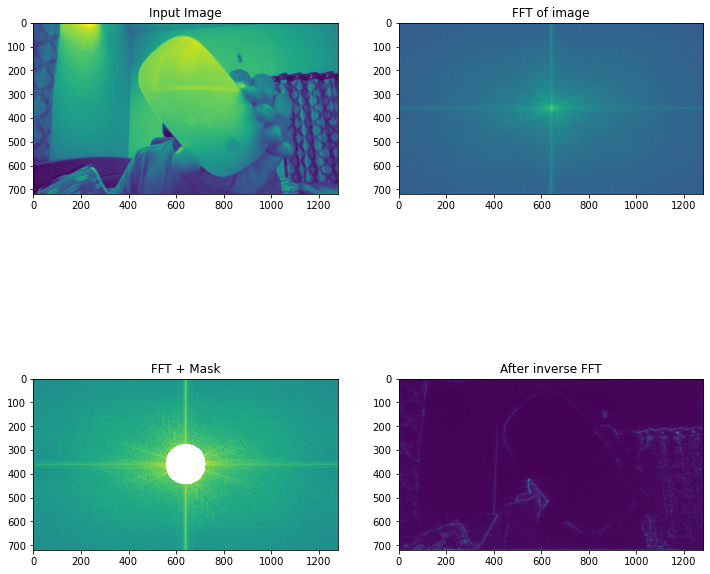

In [5]:
import cv2
from matplotlib import pyplot as plt
import numpy as np


img = cv2.imread('opencv_frame_0.png', 0) # load an image

#Output is a 2D complex array. 1st channel real and 2nd imaginary
#For fft in opencv input image needs to be converted to float32
dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)

#Rearranges a Fourier transform X by shifting the zero-frequency 
#component to the center of the array.
#Otherwise it starts at the tope left corenr of the image (array)
dft_shift = np.fft.fftshift(dft)

##Magnitude of the function is 20.log(abs(f))
#For values that are 0 we may end up with indeterminate values for log. 
#So we can add 1 to the array to avoid seeing a warning. 
magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))


# Circular HPF mask, center circle is 0, remaining all ones
#Can be used for edge detection because low frequencies at center are blocked
#and only high frequencies are allowed. Edges are high frequency components.
#Amplifies noise.

rows, cols = img.shape
crow, ccol = int(rows / 2), int(cols / 2)

mask = np.ones((rows, cols, 2), np.uint8)
r = 80
center = [crow, ccol]
x, y = np.ogrid[:rows, :cols]
mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r*r
mask[mask_area] = 0


# Circular LPF mask, center circle is 1, remaining all zeros
# Only allows low frequency components - smooth regions
#Can smooth out noise but blurs edges.
#


# apply mask and inverse DFT
fshift = dft_shift * mask

fshift_mask_mag = 2000 * np.log(cv2.magnitude(fshift[:, :, 0], fshift[:, :, 1]))

f_ishift = np.fft.ifftshift(fshift)
img_back = cv2.idft(f_ishift)
img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])



fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img)
ax1.title.set_text('Input Image')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(magnitude_spectrum)
ax2.title.set_text('FFT of image')
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(fshift_mask_mag)
ax3.title.set_text('FFT + Mask')
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(img_back)
ax4.title.set_text('After inverse FFT')
plt.show()


In [6]:
import os
import numpy as np
from numpy.fft import fft2, ifft2
from scipy.signal import gaussian, convolve2d
import matplotlib.pyplot as plt

In [7]:
def blur(img, mode = 'box', kernel_size = 3):
    # mode = 'box' or 'gaussian' or 'motion'
    dummy = np.copy(img)
    if mode == 'box':
        h = np.ones((kernel_size, kernel_size)) / kernel_size ** 2
    elif mode == 'gaussian':
        h = gaussian(kernel_size, kernel_size / 3).reshape(kernel_size, 1)
        h = np.dot(h, h.transpose())
        h /= np.sum(h)
    elif mode == 'motion':
        h = np.eye(kernel_size) / kernel_size
    dummy = convolve2d(dummy, h, mode = 'valid')
    return dummy

In [8]:
def add_gaussian_noise(img, sigma):
    gauss = np.random.normal(0, sigma, np.shape(img))
    noisy_img = img + gauss
    noisy_img[noisy_img < 0] = 0
    noisy_img[noisy_img > 255] = 255
    return noisy_img

In [9]:
def wiener_filter(img, kernel, K):
    kernel /= np.sum(kernel)
    dummy = np.copy(img)
    dummy = fft2(dummy)
    kernel = fft2(kernel, s = img.shape)
    kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + K)
    dummy = dummy * kernel
    dummy = np.abs(ifft2(dummy))
    return dummy

In [10]:
def gaussian_kernel(kernel_size = 3):
    h = gaussian(kernel_size, kernel_size / 3).reshape(kernel_size, 1)
    h = np.dot(h, h.transpose())
    h /= np.sum(h)
    return h

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [11]:
#file_name = os.path.join('opencv_frame_0.png') 
#img = rgb2gray(plt.imread(file_name))

blurred_img = blur(img, mode = 'motion', kernel_size = 3)

noisy_img = add_gaussian_noise(blurred_img, sigma = 20)

kernel = gaussian_kernel(3)

filtered_img = wiener_filter(noisy_img, kernel, K = 30)

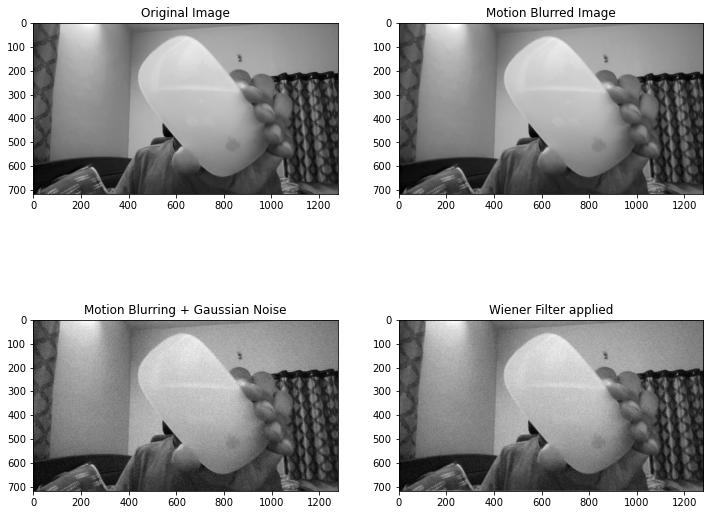

In [12]:
display = [img, blurred_img, noisy_img, filtered_img]
label = ['Original Image', 'Motion Blurred Image', 'Motion Blurring + Gaussian Noise', 'Wiener Filter applied']

fig = plt.figure(figsize=(12, 10))

for i in range(len(display)):
    fig.add_subplot(2, 2, i+1)
    plt.imshow(display[i], cmap = 'gray')
    plt.title(label[i])

plt.show()